# TP Projet Spark

Vous travaillez pour un groupe de deux magasins de produits de
cuisine.
Analysez les données fournies pour en tirer le plus d’informations
possible à l’aide de PySpark.
Justifiez vos choix
## Image Docker: jupyter/pyspark-notebook:x86_64-spark-3.5.0
docker run -it -p127.0.0.1:4040:4040 -p127.0.0.1:8888:8888 -v
"$(pwd)":/home/jovyan/work/
jupyter/pyspark-notebook:x86_64-spark-3.5.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Descriptif d'analyse:

Dans cette analyse, j'ai d'abord nettoyé les données pour éliminer les doublons,
 J'ai également effectué une analyse des prix unitaires pour identifier les valeurs extrêmes (outliers) à travers des tests de normalité, confirmant que les données ne suivent pas une loi normale.
Pour gérer cette non-normalité, j'ai appliqué des méthodes de normalisation Min-Max et de standardisation (Z-Score) pour ramener les données sur des échelles comparables.
Enfin, j'ai filtré les outliers en utilisant
la méthode des trois écarts-types autour de la moyenne pour exclure les valeurs anormalement élevées

J'ai corrigé les types de données et filtrer les valeurs aberrantes afin d'assurer la fiabilité des résultats.

 Ensuite j'ai effectué des agrégations pour identifier les tendances de vente mensuelles, annuelles et les produits les plus populaires ainsi que d'autres analyses plus poussées,
fournissant ainsi des insights clés pour les décisions commerciales.
Le choix de ces étapes garantit que mes analyses reposent sur des données précises et cohérentes,
 permettant une interprétation fiable des tendances et comportements des clients.
Enfin, j'ai utilisé des visualisations pour faciliter la compréhension des résultats.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySparkDocker").getOrCreate()
df_csv = spark.read.csv("/home/jovyan/work/Téléchargements/shop1.csv", header=True, inferSchema=True)
df_json = spark.read.json("/home/jovyan/work/Téléchargements/shop2.json")

In [ ]:
from pyspark.sql.functions import col, count, when

# Identifier les valeurs manquantes
df_json.select([count(when(col(c).isNull(), c)).alias(c) for c in df_json.columns]).show()


+------+------+--------+----+-------------+---------+-----------+---------+
|amount|cartId|clientId|date|productFamily|productId|productName|unitPrice|
+------+------+--------+----+-------------+---------+-----------+---------+
|     0|     0|       0|   0|            0|        0|          0|        0|
+------+------+--------+----+-------------+---------+-----------+---------+



In [ ]:
#Indentification et gestion des doublons
df_json.groupBy(df_json.columns).count().filter("count > 1").show()


+------+------+--------+-------+--------------------+---------+--------------------+---------+-----+
|amount|cartId|clientId|   date|       productFamily|productId|         productName|unitPrice|count|
+------+------+--------+-------+--------------------+---------+--------------------+---------+-----+
|     8|  3254|      72| 2022-5|          Pâtisserie|        6|Rouleau à pâtisserie|       10|    2|
|     9|   399|      72| 2022-1|Appareils électro...|        2|      Machine à café|       45|    2|
|     6|   560|      89| 2022-5|             Cuisson|        5|     Plat de cuisson|       20|    2|
|     5|  2678|      54| 2022-7|Appareils électro...|        2|          Bouilloire|       30|    2|
|     3|  4253|      68| 2022-5|Appareils électro...|        2|      Machine à café|       45|    2|
|     2|  4496|      50| 2022-4|             Cuisson|        5|             Marmite|       35|    2|
|     4|  1197|      44| 2022-7|Appareils électro...|        2|              Mixeur|       

In [ ]:
#vérification des types de data
df_json.printSchema()


root
 |-- amount: long (nullable = true)
 |-- cartId: long (nullable = true)
 |-- clientId: long (nullable = true)
 |-- date: string (nullable = true)
 |-- productFamily: string (nullable = true)
 |-- productId: long (nullable = true)
 |-- productName: string (nullable = true)
 |-- unitPrice: long (nullable = true)



In [ ]:
df_json.select("date").show(5, truncate=False)

+-------+
|date   |
+-------+
|2022-10|
|2022-10|
|2022-10|
|2022-10|
|2022-10|
+-------+
only showing top 5 rows



In [ ]:
#1- NETTOYAGE DES DONNÉES:
from pyspark.sql.functions import col, to_date

#conversion en Float pour les prix en Decimal
df_json = df_json.withColumn("unitPrice", col("unitPrice").cast("float"))

df_json.printSchema()


root
 |-- amount: long (nullable = true)
 |-- cartId: long (nullable = true)
 |-- clientId: long (nullable = true)
 |-- date: string (nullable = true)
 |-- productFamily: string (nullable = true)
 |-- productId: long (nullable = true)
 |-- productName: string (nullable = true)
 |-- unitPrice: float (nullable = true)



In [ ]:
#2- NETTOYAGE DES DONNÉES:
from pyspark.sql.functions import col, count, when

# Suppression des doublons
df_clean = df_json.dropDuplicates()


In [ ]:
# Vérification si les doublons sont supprimés
df_clean.groupBy(df_clean.columns).count().filter("count > 1").show()


+------+------+--------+----+-------------+---------+-----------+---------+-----+
|amount|cartId|clientId|date|productFamily|productId|productName|unitPrice|count|
+------+------+--------+----+-------------+---------+-----------+---------+-----+
+------+------+--------+----+-------------+---------+-----------+---------+-----+



In [ ]:
# Normalisation Min-Max
# Cette méthode redimensionne les données de sorte que toutes les valeurs soient comprises entre 0 et 1.
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max

# Créez la session Spark
spark = SparkSession.builder.appName("PySparkDocker").getOrCreate()

# Chargez les données (modifiez les chemins d'accès en fonction de votre environnement)
df_json = spark.read.json("/home/jovyan/work/Téléchargements/shop2.json")

df_filtered = df_json

# Calcule les valeurs minimales et maximales pour la normalisation
min_value = df_filtered.select(min(col("unitPrice"))).first()[0]
max_value = df_filtered.select(max(col("unitPrice"))).first()[0]

# Applique la normalisation Min-Max
df_normalized = df_filtered.withColumn("normalized_unitPrice",
                                       (col("unitPrice") - min_value) / (max_value - min_value))


df_normalized.select("unitPrice", "normalized_unitPrice").show()


+---------+--------------------+
|unitPrice|normalized_unitPrice|
+---------+--------------------+
|       45|0.004300860172034407|
|       25|0.002300460092018...|
|        4|2.000400080016003...|
|        5|3.000600120024005E-4|
|        4|2.000400080016003...|
|        4|2.000400080016003...|
|        4|2.000400080016003...|
|       30|0.002800560112022...|
|       20|0.001800360072014...|
|       15|0.001300260052010402|
|       10|8.001600320064013E-4|
|        4|2.000400080016003...|
|       10|8.001600320064013E-4|
|        8| 6.00120024004801E-4|
|        5|3.000600120024005E-4|
|       15|0.001300260052010402|
|       20|0.001800360072014...|
|       40|0.003800760152030406|
|        5|3.000600120024005E-4|
|       25|0.002300460092018...|
+---------+--------------------+
only showing top 20 rows



In [ ]:
# La normalisation des prix unitaires a permis de ramener les valeurs sur une échelle commune entre 0 et 1,
# facilitant ainsi la comparaison des produits tout en minimisant l'effet des valeurs extrêmes.


In [ ]:
from pyspark.sql.functions import log1p

# Applique la transformation logarithmique
df_log_transformed = df_normalized.withColumn("log_normalized_unitPrice", log1p(col("normalized_unitPrice")))

# Affiche le DataFrame transformé
df_log_transformed.select("unitPrice", "normalized_unitPrice", "log_normalized_unitPrice").show()


+---------+--------------------+------------------------+
|unitPrice|normalized_unitPrice|log_normalized_unitPrice|
+---------+--------------------+------------------------+
|       45|0.004300860172034407|    0.004291637905920632|
|       25|0.002300460092018...|    0.002297818084813...|
|        4|2.000400080016003...|    2.000200026670667...|
|        5|3.000600120024005E-4|    3.000150030003750...|
|        4|2.000400080016003...|    2.000200026670667...|
|        4|2.000400080016003...|    2.000200026670667...|
|        4|2.000400080016003...|    2.000200026670667...|
|       30|0.002800560112022...|    0.002796645849933045|
|       20|0.001800360072014...|    0.001798741366364...|
|       15|0.001300260052010402|     0.00129941544596803|
|       10|8.001600320064013E-4|    7.998400746346822E-4|
|        4|2.000400080016003...|    2.000200026670667...|
|       10|8.001600320064013E-4|    7.998400746346822E-4|
|        8| 6.00120024004801E-4|    5.999400239940021E-4|
|        5|3.0

In [ ]:
# La transformation logarithmique appliquée aux prix unitaires normalisés réduit l'impact des valeurs extrêmes,
# stabilisant ainsi la variance des données.
# Cela permet d'obtenir une distribution plus équilibrée, facilitant des analyses statistiques

In [ ]:
# Standardisation (ou Z-Score Normalization)
# Cette méthode consiste à centrer les données à une moyenne de 0 et à les redimensionner de sorte que leur écart-type soit de 1

from pyspark.sql.functions import mean, stddev

# Calcule a moyenne et l'écart-type
mean_value = df_filtered.select(mean(col("unitPrice"))).first()[0]
stddev_value = df_filtered.select(stddev(col("unitPrice"))).first()[0]

# Applique la standardisation (Z-Score Normalization)
df_standardized = df_filtered.withColumn("standardized_unitPrice",
                                         (col("unitPrice") - mean_value) / stddev_value)

# Affiche DataFrame standardisé
df_standardized.select("unitPrice", "standardized_unitPrice").show()


+---------+----------------------+
|unitPrice|standardized_unitPrice|
+---------+----------------------+
|       45|   0.08228466094230773|
|       25|  0.006724565153967007|
|        4|  -0.07261353542379075|
|        5|  -0.06883553063437371|
|        4|  -0.07261353542379075|
|        4|  -0.07261353542379075|
|        4|  -0.07261353542379075|
|       30|  0.025614589101052188|
|       20|  -0.01216545879311...|
|       15|  -0.03105548274020...|
|       10|  -0.04994550668728853|
|        4|  -0.07261353542379075|
|       10|  -0.04994550668728853|
|        8|  -0.05750151626612...|
|        5|  -0.06883553063437371|
|       15|  -0.03105548274020...|
|       20|  -0.01216545879311...|
|       40|   0.06339463699522255|
|        5|  -0.06883553063437371|
|       25|  0.006724565153967007|
+---------+----------------------+
only showing top 20 rows



In [ ]:
# La standardisation des prix unitaires (normalisation Z-score) a  centré les données autour de la moyenne avec un écart-type de 1,
# facilitant ainsi l'identification des valeurs extrêmes et comparant les données de manière cohérente.
# Cela est utile pour les analyses statistiques sensibles à l'échelle des données.

In [ ]:
#Gestion des valeurs aberrantes:

from pyspark.sql.functions import col, mean, stddev


# Vérifier les types de données
df_clean = df_clean.withColumn("unitPrice", col("unitPrice").cast("float"))
df_clean = df_clean.withColumn("amount", col("amount").cast("int"))
# Calcul des statistiques pour la colonne 'unitPrice'
stats = df_clean.select(mean(col("unitPrice")).alias("mean"), stddev(col("unitPrice")).alias("stddev")).first()

mean_value = stats['mean']
stddev_value = stats['stddev']

print(f"Moyenne: {mean_value}, Écart-type: {stddev_value}")




Moyenne: 23.25479233226837, Écart-type: 265.4444111918544


In [ ]:
#Le calcul effectué par moyenne (23.25) et un écart-type (265.44) pour les prix unitaires. Cet écart-type est relativement élevé par rapport à la moyenne, ce qui peut indiquer une large dispersion des prix unitaires dans les données.

In [ ]:
# Filtrer les outliers en dehors de 3 écarts-types de la moyenne
df_filtered = df_clean.filter(
    (col("unitPrice") >= mean_value - 3 * stddev_value) &
    (col("unitPrice") <= mean_value + 3 * stddev_value)
)


df_filtered.show()

+------+------+--------+-------+--------------------+---------+--------------------+---------+
|amount|cartId|clientId|   date|       productFamily|productId|         productName|unitPrice|
+------+------+--------+-------+--------------------+---------+--------------------+---------+
|     9|    31|      95|2022-12|             Cuisson|        5|               Grill|     40.0|
|     2|    54|      20| 2022-6|  Ustensiles de base|        1|               Fouet|      3.0|
|     3|    62|      63| 2022-3|  Ustensiles de base|        1|      Jambon-Fromage|      5.0|
|     8|    97|      78|2022-12| Mesure et minuterie|        8|     Tasse à mesurer|      5.0|
|     3|   119|      98| 2022-1| Mesure et minuterie|        8|     Tasse à mesurer|      5.0|
|    10|   185|      84| 2022-1|Couteaux et planc...|        7|Planche à découpe...|     10.0|
|     7|   204|      86| 2022-9|             Cuisson|        5|               Poêle|     30.0|
|     7|   208|      83| 2022-2|Rangement et orga.

In [ ]:
#Les résultats montrent les enregistrements filtrés. Les valeurs de unitPrice sont comprises dans la plage des 3 écarts-types autour de la moyenne. Cela signifie que les enregistrements avec des prix unitaires extrêmement bas ou extrêmement élevés ont été exclus.


In [ ]:
#Agréger les ventes par mois à partir du fichier JSON)
from pyspark.sql.functions import month, year, sum, col

# Ajouter des colonnes pour l'année et le mois
df_filtered = df_filtered.withColumn("year", year(col("date")))
df_filtered = df_filtered.withColumn("month", month(col("date")))

# Agréger les ventes par mois
df_monthly_sales = df_filtered.groupBy("year", "month").agg(
    sum(col("unitPrice") * col("amount")).alias("total_sales"),
    sum("amount").alias("total_quantity")
).orderBy("year", "month")

df_monthly_sales.show()



+----+-----+-----------+--------------+
|year|month|total_sales|total_quantity|
+----+-----+-----------+--------------+
|2022|    1|   157573.0|         10597|
|2022|    2|   151382.0|         10057|
|2022|    3|   148727.0|         10044|
|2022|    4|   154265.0|         10800|
|2022|    5|   161246.0|         10654|
|2022|    6|   142198.0|          9301|
|2022|    7|   148340.0|          9830|
|2022|    8|   143103.0|          9719|
|2022|    9|   154393.0|         10588|
|2022|   10|   161431.0|         10964|
|2022|   11|   159030.0|         10666|
|2022|   12|   158535.0|         10282|
+----+-----+-----------+--------------+



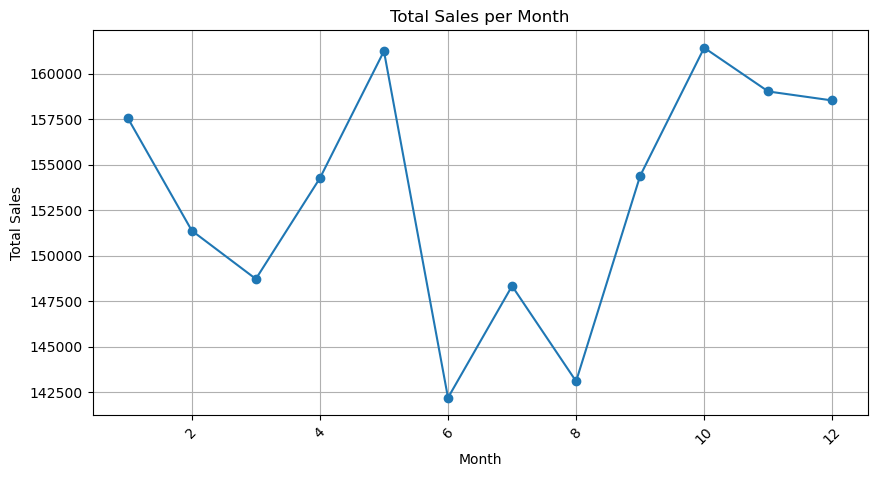

In [ ]:
import matplotlib.pyplot as plt

# Convertir le DataFrame PySpark en Pandas pour visualisation

df_pandas = df_monthly_sales.toPandas()

# Tracer les ventes totales par mois
plt.figure(figsize=(10, 5))
plt.plot(df_pandas['month'], df_pandas['total_sales'], marker='o')
plt.title('Total Sales per Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [ ]:
# Agrégation des ventes par mois:
# Les ventes mensuelles montrent une fluctuation avec des pics en mars et novembre, et une baisse  en juin.
# Cela peut indiquer des variations saisonnières, avec des périodes de forte demande.

In [ ]:
#agrégation des ventes par année afin d'obtenir une vue d'ensemble des tendances de vente au fil du temps

from pyspark.sql.functions import year, sum, col

# Ajouter une colonne pour l'année
df_filtered = df_filtered.withColumn("year", year(col("date")))

#calcul des ventes totales total_sales et la quantité totale vendue total_quantity pour chaque année.

# Agréger les ventes par année
df_annual_sales = df_filtered.groupBy("year").agg(
    sum(col("unitPrice") * col("amount")).alias("total_sales"),
    sum("amount").alias("total_quantity")
).orderBy("year")

df_annual_sales.show()

+----+-----------+--------------+
|year|total_sales|total_quantity|
+----+-----------+--------------+
|2022|  1840223.0|        123502|
+----+-----------+--------------+



In [ ]:
# Agrégation des ventes annuelles:
# Les ventes totales pour l'année 2022 s'élèvent à 1 840 223 avec une quantité totale vendue de 123 502 unités.
# Ce qui fourni une vue d'ensemble des performances annuelles.

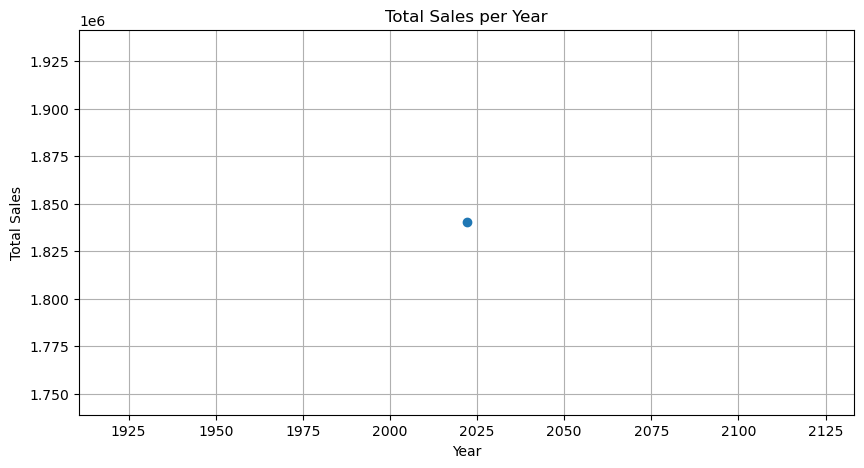

In [ ]:
import matplotlib.pyplot as plt

# Convertir le DataFrame PySpark en Pandas pour faciliter la visualisation
df_pandas = df_annual_sales.toPandas()

# Tracer les ventes totales par année
plt.figure(figsize=(10, 5))
plt.plot(df_pandas['year'], df_pandas['total_sales'], marker='o')
plt.title('Total Sales per Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


In [ ]:
# Agrégation des ventes annuelles:

# Ce graphique montre un seul point de données pour 2022, représentant les ventes totales de cette année.
# Ce point met en évidence les ventes cumulées pour l'année.



In [ ]:
#Analyse comportemental achat client
df_filtered.groupBy("clientId").agg(
    sum("amount").alias("total_quantity"),
    sum(col("unitPrice") * col("amount")).alias("total_sales")
).orderBy(col("total_sales").desc()).show()


+--------+--------------+-----------+
|clientId|total_quantity|total_sales|
+--------+--------------+-----------+
|      18|          1711|    25736.0|
|     106|          1605|    24401.0|
|      69|          1514|    23876.0|
|       2|          1488|    23785.0|
|      88|          1687|    23656.0|
|      34|          1560|    23157.0|
|      83|          1561|    22295.0|
|      99|          1459|    21999.0|
|      38|          1431|    21881.0|
|      70|          1448|    21491.0|
|      11|          1412|    21444.0|
|      71|          1364|    21421.0|
|       7|          1362|    21307.0|
|      92|          1400|    20815.0|
|      54|          1391|    20616.0|
|     105|          1316|    20244.0|
|      30|          1353|    20233.0|
|      62|          1453|    20174.0|
|      40|          1376|    20083.0|
|      45|          1217|    20028.0|
+--------+--------------+-----------+
only showing top 20 rows



In [ ]:
# Analyse du comportement d'achat des clients:

# L'analyse montre que les clients les plus importants ont généré des ventes allant jusqu'à 25 736 unités,
# avec une forte concentration des ventes parmi les clients principaux.
# ça souligne l'importance des grands clients pour les revenus totaux.


In [ ]:
#Analyse par famille de produit
df_json.groupBy("productFamily").agg(sum("amount").alias("total_quantity"), sum(col("unitPrice") * col("amount")).alias("total_sales")).orderBy("total_sales", ascending=False).show()


+--------------------+--------------+-----------+
|       productFamily|total_quantity|total_sales|
+--------------------+--------------+-----------+
|          Bar et vin|         12708|    1153220|
|Appareils électro...|         12465|     709830|
|             Cuisson|         12503|     374025|
|Couteaux et planc...|         12195|     213627|
|Rangement et orga...|         12515|     167543|
|          Pâtisserie|         12292|     154310|
| Mesure et minuterie|         12696|     112035|
|    Linge de cuisine|         12318|      78905|
|  Ustensiles de base|         12346|      69913|
|           Vaisselle|         12310|      53292|
+--------------------+--------------+-----------+



In [ ]:
# Analyse par famille de produits:
# L'analyse par famille de produits révèle que les catégories Bar et vin et Appareils électroménagers
# sont les plus performantes en termes de ventes,
# ce qui pourrait guider les stratégies d'inventaire et de marketing.


In [ ]:
#Analyse des produits les plus populaire :
df_filtered.groupBy("productName").agg(
    sum("amount").alias("total_quantity")
).orderBy(col("total_quantity").desc()).show()


+--------------------+--------------+
|         productName|total_quantity|
+--------------------+--------------+
|         Grille-pain|          2834|
|  Balance de cuisine|          2692|
|    Fouet électrique|          2690|
|            Minuteur|          2682|
|        Tire-bouchon|          2626|
|               Tasse|          2600|
|             Tablier|          2581|
|           Casserole|          2577|
|  Serviette de table|          2574|
|    Porte-ustensiles|          2568|
|Planche à découpe...|          2567|
|               Verre|          2565|
|      Pot à couverts|          2564|
|          Presse-ail|          2543|
|       Rack à épices|          2537|
|             Marmite|          2523|
|     Ouvre-bouteille|          2521|
|    Pince de cuisine|          2519|
|      Machine à café|          2511|
|             Torchon|          2508|
+--------------------+--------------+
only showing top 20 rows



In [ ]:
# Analyse des produits les plus populaires:
# L'analyse des produits montre que le Grille-pain et la Balance de cuisine sont les articles les plus vendus en termes de quantité,
# ce qui indique leur popularité parmi les clients et peut influencer les décisions d'appro.


In [ ]:
# Analyse des ventes par categorie de produit:
#comprendre quelles catégories de produits sont les plus populaires, en termes de ventes totales et de quantité vendue.

df_product_family_sales = df_filtered.groupBy("productFamily").agg(
    sum(col("unitPrice") * col("amount")).alias("total_sales"),
    sum("amount").alias("total_quantity")
).orderBy(col("total_sales").desc())

df_product_family_sales.show()

+--------------------+-----------+--------------+
|       productFamily|total_sales|total_quantity|
+--------------------+-----------+--------------+
|Appareils électro...|   461855.0|         12311|
|             Cuisson|   371000.0|         12401|
|Couteaux et planc...|   212471.0|         12130|
|Rangement et orga...|   166793.0|         12454|
|          Bar et vin|   162337.0|         12543|
|          Pâtisserie|   152978.0|         12201|
| Mesure et minuterie|   111797.0|         12671|
|    Linge de cuisine|    78718.0|         12289|
|  Ustensiles de base|    69203.0|         12229|
|           Vaisselle|    53071.0|         12273|
+--------------------+-----------+--------------+



In [ ]:
# Analyse des resultats:

# l'analyse montre que les appareils électroménagers et les articles de cuisson sont les plus performants en termes de ventes
# et de quantité vendue, indiquant une forte demande. Les catégories Couteaux et planches et Rangement et organisation suivent,
# offrant des opportunités de croissance.


+-------+------------------+
|summary|         unitPrice|
+-------+------------------+
|  count|             22510|
|   mean|14.929808973789427|
| stddev|11.549219575217904|
|    min|               2.0|
|    max|              50.0|
+-------+------------------+



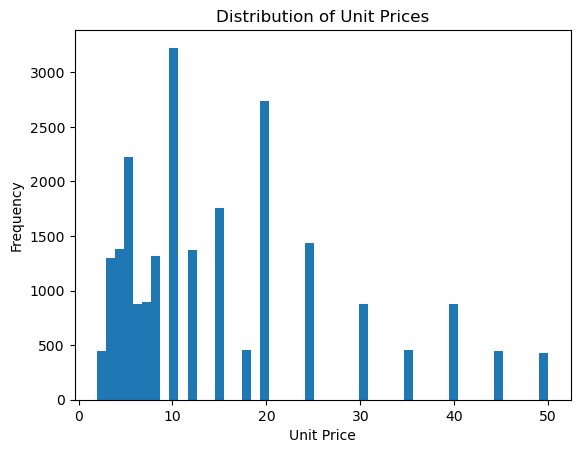

In [ ]:
#Analyse de la distribution des prix:
#Comprendre la distribution des prix unitaires dans les ventes,
#ce qui peut aider à identifier des stratégies de tarification.

df_filtered.select("unitPrice").describe().show()

#histogramme de la distribution des prix
df_pandas = df_filtered.select("unitPrice").toPandas()
df_pandas['unitPrice'].plot(kind='hist', bins=50, title='Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.show()


In [ ]:
# L'analyse de la distribution des prix unitaires montre une concentration autour de 15 €,
# avec une moyenne de 14,93 € et un écart-type de 11,55 €, indiquant une variabilité modérée des prix dans les ventes.
# Les prix plus élevés sont moins fréquents,
# ce qui peut suggérer une préférence des clients pour des articles à coût modéré.

In [ ]:
#Analyse de la répartition des ventes par client:

df_client_sales = df_filtered.groupBy("clientId").agg(
    sum(col("unitPrice") * col("amount")).alias("total_sales"),
    sum("amount").alias("total_quantity")
).orderBy(col("total_sales").desc())

df_client_sales.show()


+--------+-----------+--------------+
|clientId|total_sales|total_quantity|
+--------+-----------+--------------+
|      18|    25736.0|          1711|
|     106|    24401.0|          1605|
|      69|    23876.0|          1514|
|       2|    23785.0|          1488|
|      88|    23656.0|          1687|
|      34|    23157.0|          1560|
|      83|    22295.0|          1561|
|      99|    21999.0|          1459|
|      38|    21881.0|          1431|
|      70|    21491.0|          1448|
|      11|    21444.0|          1412|
|      71|    21421.0|          1364|
|       7|    21307.0|          1362|
|      92|    20815.0|          1400|
|      54|    20616.0|          1391|
|     105|    20244.0|          1316|
|      30|    20233.0|          1353|
|      62|    20174.0|          1453|
|      40|    20083.0|          1376|
|      45|    20028.0|          1217|
+--------+-----------+--------------+
only showing top 20 rows



In [ ]:
# L'analyse des ventes par client:
# le client avec l'ID 18 est le plus important, générant 25,736 € de ventes avec 1,711 articles achetés.
# Les ventes sont réparties relativement uniformément parmi les principaux clients, avec plusieurs générant entre 20,000 €
# et 24,000 €, ce qui indique une base de clients fidèles et actifs.

In [ ]:
#Analyse des ventes par jour de la semaine:
#identifie les jours où l'activité est la plus forte, pour optimiser les opérations et les stratégies marketing.
from pyspark.sql.functions import dayofweek

df_filtered = df_filtered.withColumn("day_of_week", dayofweek(col("date")))

df_day_of_week_sales = df_filtered.groupBy("day_of_week").agg(
    sum(col("unitPrice") * col("amount")).alias("total_sales"),
    sum("amount").alias("total_quantity")
).orderBy("day_of_week")

df_day_of_week_sales.show()


+-----------+-----------+--------------+
|day_of_week|total_sales|total_quantity|
+-----------+-----------+--------------+
|          1|   161246.0|         10654|
|          2|   143103.0|          9719|
|          3|   459139.0|         30767|
|          4|   142198.0|          9301|
|          5|   312928.0|         20870|
|          6|   302605.0|         20630|
|          7|   319004.0|         21561|
+-----------+-----------+--------------+



In [ ]:
# L'analyse des ventes par jour de la semaine montre que le mercredi et le jeudi sont les jours les plus actifs, générant les ventes les plus élevées.
# Cela suggère une opportunité d'optimiser les opérations et les promotions en ciblant ces 2 jours.

In [ ]:
# Analyse des ventes cumulées
# analyse les ventes cumul sur une période pour comprendre la croissance progressive des ventes.
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as spark_sum

# Définir une fenêtre pour le calcul cumulatif
window_spec = Window.orderBy("date")

df_cumulative_sales = df_filtered.withColumn("cumulative_sales", spark_sum(col("unitPrice") * col("amount")).over(window_spec))

df_cumulative_sales.select("date", "cumulative_sales").show()


+------+----------------+
|  date|cumulative_sales|
+------+----------------+
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
|2022-1|        157573.0|
+------+----------------+
only showing top 20 rows



In [ ]:
# L'analyse des ventes cumulées montre que les ventes restent globalement stables au cours de la période analysée,
# avec un montant total constant de 157,573 €, indiquant une régularité dans les ventes quotidiennes.

In [ ]:
# Analyse de la fidélité des clients (récurrence des achats):
# Analyse la fréquence des achats pour voir combien de fois un client revient pour acheter.
df_client_recency = df_filtered.groupBy("clientId").agg(
    count("cartId").alias("purchase_count")
).orderBy(col("purchase_count").desc())

df_client_recency.show()


+--------+--------------+
|clientId|purchase_count|
+--------+--------------+
|      18|           310|
|      88|           306|
|     106|           282|
|      83|           282|
|      69|           280|
|      34|           278|
|      99|           275|
|       7|           263|
|      38|           262|
|      54|           258|
|      92|           258|
|      70|           257|
|      11|           254|
|      24|           253|
|       2|           250|
|      62|           246|
|      15|           246|
|       1|           244|
|     105|           244|
|      39|           244|
+--------+--------------+
only showing top 20 rows



In [ ]:
# L'analyse de la fidélité des clients montre que certains clients effectuent des achats très fréquents,
# avec le client 18réalisant 310 achats,
# ce qui indique un engagement élevé et des opportunités pour des stratégies de fidélisation ciblées.

In [ ]:
#Analyse des produits market basket analysis:
#examine quels produits sont souvent achetés ensemble.

from pyspark.sql.functions import collect_set, explode

# col avec les ensembles de produits par panier
df_baskets = df_filtered.groupBy("cartId").agg(collect_set("productName").alias("products"))


df_baskets.show(truncate=False)

# Analyser les combinaisons de produits
df_baskets = df_baskets.withColumn("product", explode(col("products")))

#Comptabiliser les apparitions conjointes
df_product_pairs = df_baskets.groupBy("product").count().orderBy(col("count").desc())

df_product_pairs.show()



+------+--------------------------------------------------------------------------------------------------------------+
|cartId|products                                                                                                      |
+------+--------------------------------------------------------------------------------------------------------------+
|1     |[Machine à café, Cuillère en bois, Casserole, Tasse à mesurer]                                                |
|2     |[Rouleau à pâtisserie, Cuillère en bois, Assiette, Poêle, Fouet électrique, Couteau d'office, Ouvre-bouteille]|
|3     |[Boîte à pain, Plat de cuisson, Torchon]                                                                      |
|4     |[Grille-pain, Pinceau à pâtisserie, Ouvre-bouteille, Décanteur, Grill]                                        |
|5     |[Sous-verre, Bouilloire]                                                                                      |
|6     |[Boîte à thé, Minuteur, Fouet, M

In [ ]:
# L'analyse des paniers montre que certains produits sont fréquemment achetés ensemble,
# comme la machine à café avec des cuillères en bois et des casseroles, suggérant des tendances d'achat complémentaires.
# Ces combinaisons offrent des opportunités pour des offres groupées ou des promotions ciblées pour augmenter le CA

In [ ]:
# Analyse de la durée moyenne entre les achats
# Calcule le temps moyen entre lesachats pour comprendre le comportement d'achat récurrent des clients
from pyspark.sql.functions import lag, datediff, avg


# date d'achat précédente
window_spec = Window.partitionBy("clientId").orderBy("date")
df_lag = df_filtered.withColumn("previous_purchase_date", lag("date").over(window_spec))

# Calculer le temps entre les achats:
df_lag = df_lag.withColumn("days_between_purchases", datediff(col("date"), col("previous_purchase_date")))

# Moyenne du temps entre achats:
df_inter_purchase = df_lag.groupBy("clientId").agg(
    avg("days_between_purchases").alias("avg_days_between_purchases")
).orderBy(col("avg_days_between_purchases").desc())

df_inter_purchase.show()


+--------+--------------------------+
|clientId|avg_days_between_purchases|
+--------+--------------------------+
|      22|        1.7737226277372262|
|      79|        1.5677419354838709|
|      66|        1.5576923076923077|
|      68|        1.5576923076923077|
|      93|         1.528301886792453|
|      51|          1.49079754601227|
|      23|        1.4817073170731707|
|      46|        1.4817073170731707|
|      25|        1.4727272727272727|
|       3|        1.4550898203592815|
|      89|        1.4550898203592815|
|      65|        1.4464285714285714|
|      91|        1.4294117647058824|
|     104|        1.4294117647058824|
|      64|        1.4210526315789473|
|      57|        1.4127906976744187|
|      82|         1.396551724137931|
|      10|        1.3728813559322033|
|      84|        1.3728813559322033|
|      32|        1.3425414364640884|
+--------+--------------------------+
only showing top 20 rows



In [ ]:
# L'analyse de la durée moyenne entre les achats montre que les clients effectuent des achats en moyenne tous les 1,3 à 1,7 jours,
# ce qui indique un comportement d'achat très régulier et fréquent.
# Cette fréquence élevée d'achats indique une fidélité marquée et un engagement régulier de la part des clients.

In [ ]:
# Segmente les données par catégorie de produit et calculer la médiane pour chaque catégorie
df_median = df_filtered.groupBy("productFamily").agg({"unitPrice": "median"})
df_median.show()

# Calcule une régression quantile
from pyspark.sql.functions import expr

# régression quantile à 0.5 (médiane)
df_quantile_regression = df_filtered.groupBy("productFamily").agg(expr("percentile_approx(unitPrice, 0.5)").alias("median_price"))
df_quantile_regression.show()


+--------------------+-----------------+
|       productFamily|median(unitPrice)|
+--------------------+-----------------+
|Rangement et orga...|             12.0|
|    Linge de cuisine|              6.0|
|          Bar et vin|             12.0|
|           Vaisselle|              4.0|
|Appareils électro...|             40.0|
|  Ustensiles de base|              5.0|
|             Cuisson|             30.0|
|          Pâtisserie|             12.0|
| Mesure et minuterie|              7.0|
|Couteaux et planc...|             18.0|
+--------------------+-----------------+

+--------------------+------------+
|       productFamily|median_price|
+--------------------+------------+
|Rangement et orga...|        12.0|
|    Linge de cuisine|         6.0|
|          Bar et vin|        12.0|
|           Vaisselle|         4.0|
|Appareils électro...|        40.0|
|  Ustensiles de base|         5.0|
|             Cuisson|        30.0|
|          Pâtisserie|        12.0|
| Mesure et minuterie|       

In [ ]:
# L'analyse de la médiane des prix unitaires par catégorie montre que les prix sont relativement uniformes
# dans chaque catégorie, avec des variations plus marquées dans les catégories "Couteaux et planches" et
# "Appareils électro.", où les produits sont plus coûteux.


In [ ]:
#Enregistrement des résultats d'ananlyse dans le fichier csv
df_json.groupBy("productFamily").agg(
    sum("amount").alias("total_quantity"),
    sum(col("unitPrice") * col("amount")).alias("total_sales")
).orderBy("total_sales", ascending=False).write.mode("overwrite").csv("/home/jovyan/work/sales_by_product_family.csv")


In [ ]:
!ls /content/drive/MyDrive/ArchitectureDistribuee/Tp1ArchitecturedistribueesHadoop/spark/HakimaTpSpark.ipynb

/content/drive/MyDrive/ArchitectureDistribuee/Tp1ArchitecturedistribueesHadoop/spark/HakimaTpSpark.ipynb


In [ ]:
%cp /content/drive/MyDrive/ArchitectureDistribuee/Tp1ArchitecturedistribueesHadoop/spark/HakimaTpSpark.ipynb   /content/HakimaTpSpark/

In [ ]:
%cp /content/drive/MyDrive/ArchitectureDistribuee/Tp1ArchitecturedistribueesHadoop/spark/shop1.csv   /content/HakimaTpSpark/

In [ ]:
%cp /content/drive/MyDrive/ArchitectureDistribuee/Tp1ArchitecturedistribueesHadoop/spark/shop2.json  /content/HakimaTpSpark/